In [1]:
# Imports and scripts
#import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import GatherData as Gather
    import Graphs
    import Utils
import ray
ray.shutdown()
ray.init()

system = 'jabref'

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2021-05-10 05:22:16,596	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8266


In [2]:
# File containing settings
path_to_yaml = '../config.yaml'
config = Utils.read_yaml_file(path_to_yaml)

files = config['file locations'][system]
preprocess_settings = config['preprocess settings list']

In [3]:
# set file_locations which will be relative to computer in use
from pathlib import Path
raw_data_csv = str(Path.cwd().parent / files['raw data'])
system_folder = str(Path.cwd().parent / files['system folder'])
tmp_csv = str(Path.cwd().parent / files['tmp data'])
table_file = str(Path.cwd().parent / files['preprocess comparisons'])

In [4]:
Gather.gather_architectural_concerns_data(system_folder, raw_data_csv)

To request implementation, send an email to feature_requests@modin.org.


Text(0.5, 1.0, 'File distribution of the software architectural concerns for jabref')

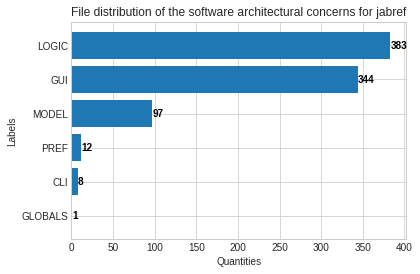

In [5]:
dataset_df = pd.read_csv(raw_data_csv)
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Quantities')
plt.ylabel('Labels')
plt.title('File distribution of the software architectural concerns for ' + system)

In [6]:
df_columns = [
    'classifier',
    'setting_id',
    'Feature rep.',
    'settings', 
    'accuracy', 
    'macro_precision', 
    'macro_recall',
    'weighted_precision',
    'weighted_recall',
    'macro_f1',
    'weighted_f1',
    'train_size', 
    'test_size', 
    'report_table' 
]
main_table = pd.DataFrame(columns=df_columns)
test_size=0.9
fold_quantity = 100

for setting_id, setting in preprocess_settings.items():
    Prep.preprocess_settings(setting, raw_data_csv, tmp_csv)
    tmp_df = pd.read_csv(tmp_csv)

    # Remove GLOBALS and CLI from the dataset
    df_sliced = Utils.remove_concerns_under_quantity_threshold(tmp_df)

    feature_bow = CountVectorizer()
    feature_tfidf = TfidfVectorizer(use_idf = True)
    confusion_list = []

    # Train and gather evaluation metrics with Bag-Of-Words
    evaluate = Eva.Evaluation(df_sliced, feature_bow, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)
                                     

    # Train and gather evaluation metrics with TF-IDF
    evaluate = Eva.Evaluation(df_sliced, feature_tfidf, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)


main_table.to_csv(table_file, index=False)

In [7]:

main_table.sort_values(by='accuracy',ascending=[False])

,classifier,setting_id,Feature rep.,settings,accuracy,macro_precision,macro_recall,weighted_precision,weighted_recall,macro_f1,weighted_f1,train_size,test_size,report_table
1,SVM,s0,Bag-of-words,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]]",0.921647,0.758002,0.707893,0.917145,0.921647,0.715343,0.918014,83,753,GUI LOGIC MODEL ...
25,SVM,s4,Bag-of-words,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]...",0.917663,0.741073,0.736072,0.916827,0.917663,0.73477,0.916604,83,753,GUI LOGIC MODEL ...
0,MaxEnt,s0,Bag-of-words,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]]",0.909695,0.657112,0.698136,0.917897,0.909695,0.672625,0.911162,83,753,GUI LOGIC MODEL ...
24,MaxEnt,s4,Bag-of-words,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]...",0.908367,0.667453,0.696266,0.90148,0.908367,0.679216,0.902353,83,753,GUI LOGIC MODEL ...
2,Naive-Bayes,s0,Bag-of-words,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]]",0.883134,0.745861,0.697342,0.886605,0.883134,0.709428,0.879367,83,753,GUI LOGIC MODEL ...
3,MaxEnt,s0,TF-IDF,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]]",0.880478,0.87106,0.730438,0.896988,0.880478,0.743269,0.882719,83,753,GUI LOGIC MODEL ...
27,MaxEnt,s4,TF-IDF,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]...",0.87915,0.680802,0.71473,0.895263,0.87915,0.689981,0.883245,83,753,GUI LOGIC MODEL ...
4,SVM,s0,TF-IDF,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]]",0.877822,0.627343,0.675956,0.882184,0.877822,0.644915,0.876422,83,753,GUI LOGIC MODEL ...
26,Naive-Bayes,s4,Bag-of-words,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]...",0.877822,0.727152,0.714029,0.875316,0.877822,0.719696,0.875857,83,753,GUI LOGIC MODEL ...
28,SVM,s4,TF-IDF,"[[lib, tow, scw, jk, lc, stem], [pac, tow, jk]...",0.875166,0.632161,0.643849,0.872935,0.875166,0.635987,0.871135,83,753,GUI LOGIC MODEL ...


2021-05-10 05:53:12,547	ERROR worker.py:1053 -- Possible unhandled error from worker: ray::deploy_ray_func() (pid=3083071, ip=10.8.8.49)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 114, in deploy_ray_func
    result = func(*args)
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/base/frame/axis_partition.py", line 294, in deploy_axis_func
    if sum(lengths) != len(result.columns):
AttributeError: 'int' object has no attribute 'columns'
2021-05-10 05:53:12,548	ERROR worker.py:1053 -- Possible unhandled error from worker: ray::deploy_ray_func() (pid=3083072, ip=10.8.8.49)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_parti